<a href="https://colab.research.google.com/github/rustambaku13/OMR/blob/master/Muscima_OMR_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas
import numpy as np
import keras
import matplotlib.pyplot as plt
import os
import cv2
import muscima
from muscima.io import parse_cropobject_list

Using TensorFlow backend.


In [0]:
os.environ['HOME']

'/Users/rustamquliyev'

In [0]:
CROPOBJECT_DIR = os.path.join(os.environ['HOME'], 'Documents/MachineLearning/OMR/v1.0/data/cropobjects_withstaff')
cropobject_fnames = [os.path.join(CROPOBJECT_DIR, f) for f in os.listdir(CROPOBJECT_DIR)]
docs = [parse_cropobject_list(f) for f in cropobject_fnames]

In [0]:
docs[0][0].

'notehead-full'

# List of all different signatures in the datasheet

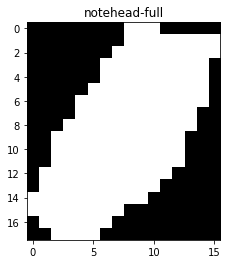

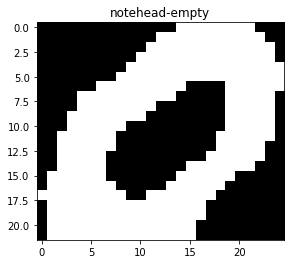

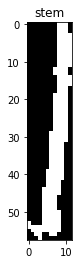

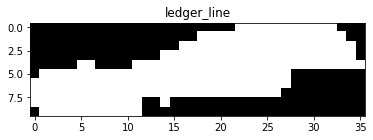

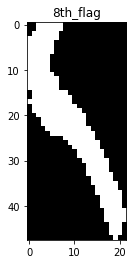

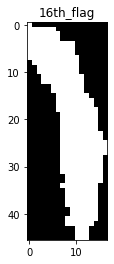

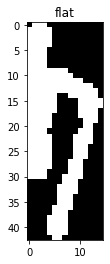

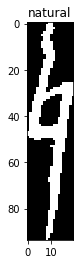

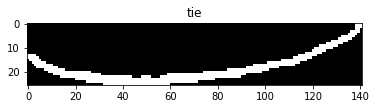

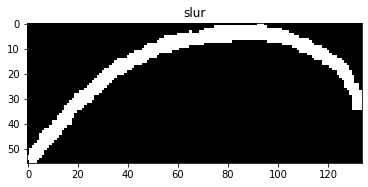

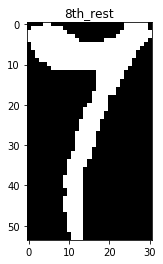

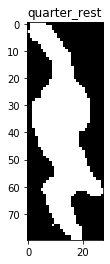

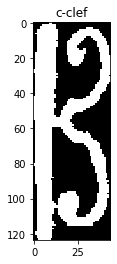

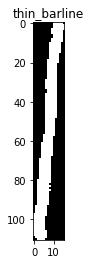

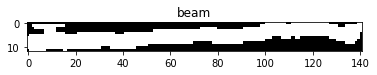

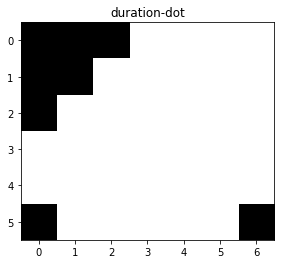

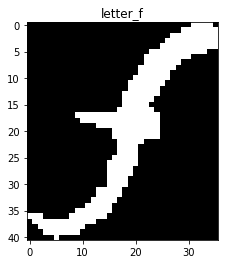

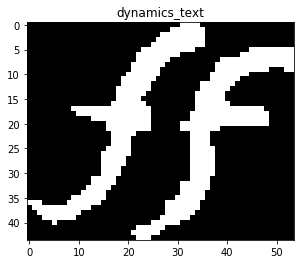

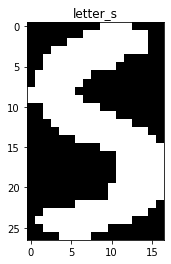

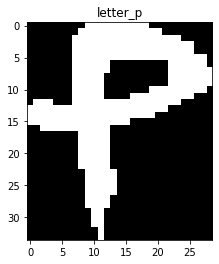

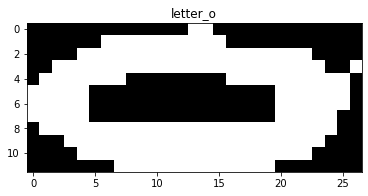

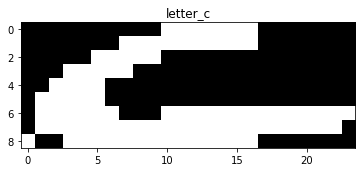

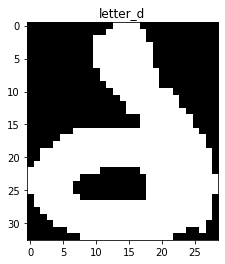

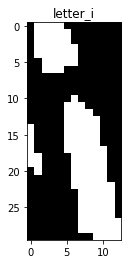

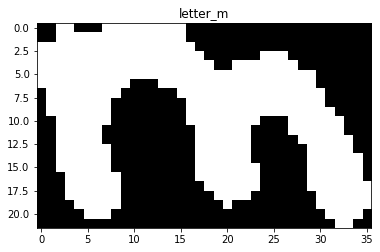

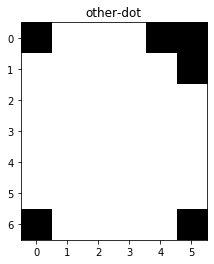

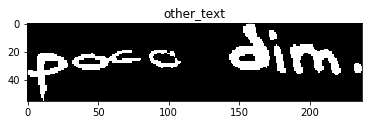

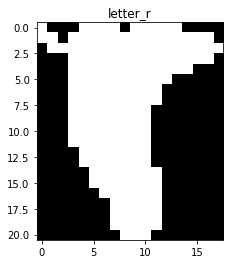

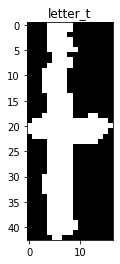

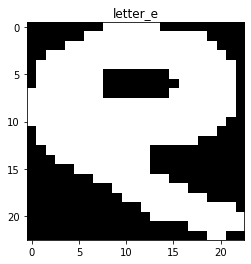

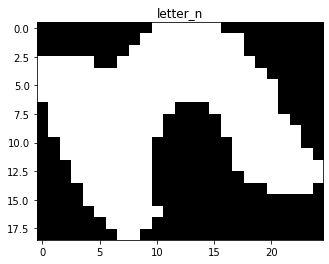

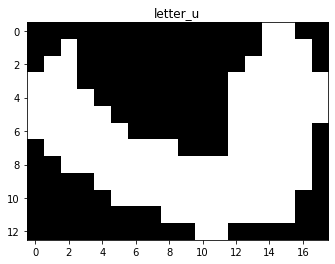

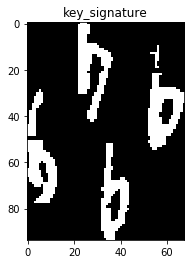

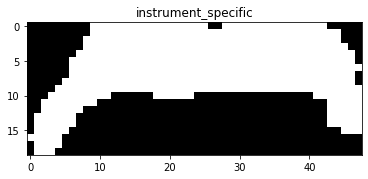

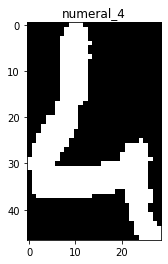

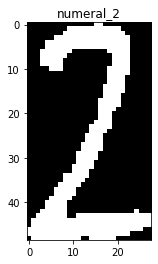

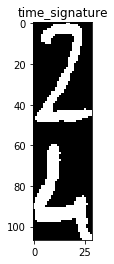

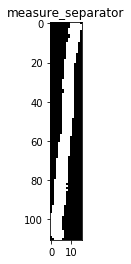

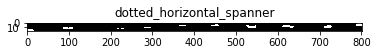

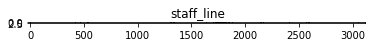

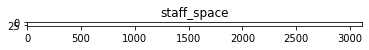

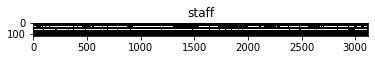

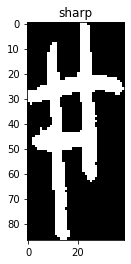

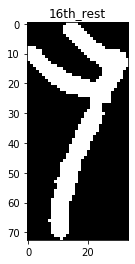

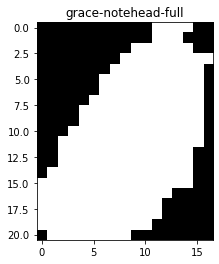

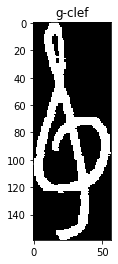

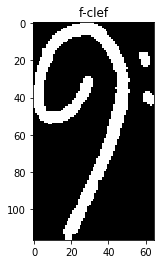

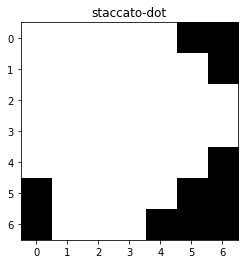

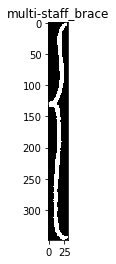

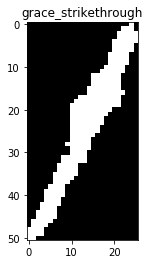

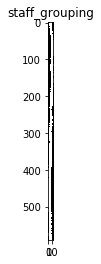

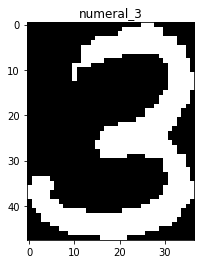

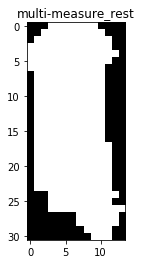

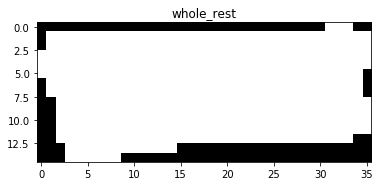

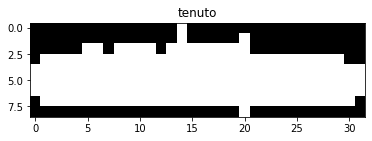

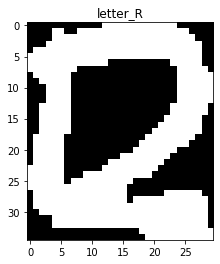

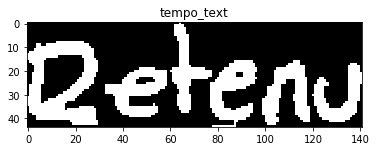

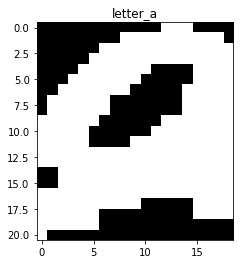

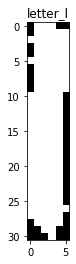

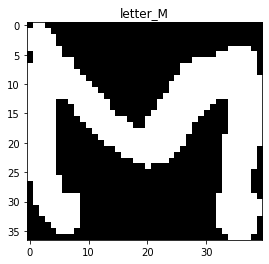

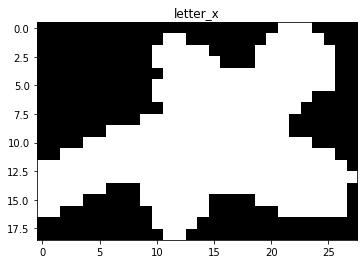

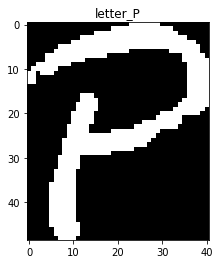

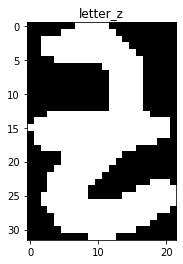

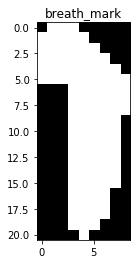

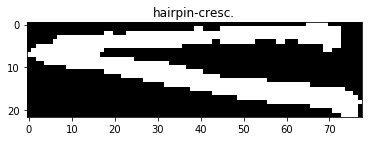

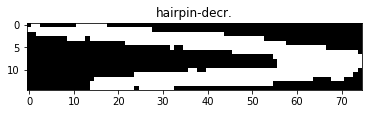

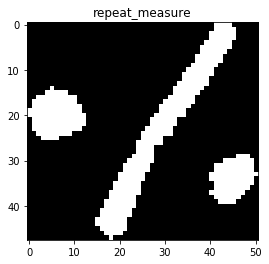

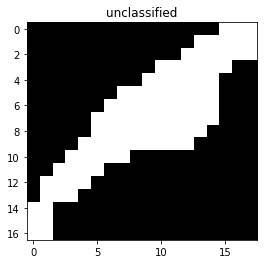

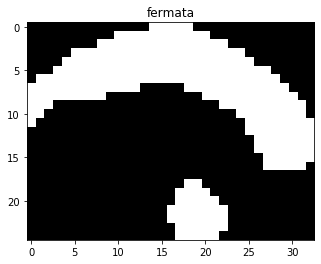

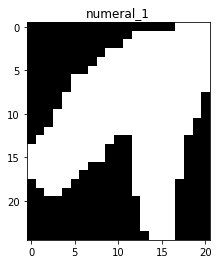

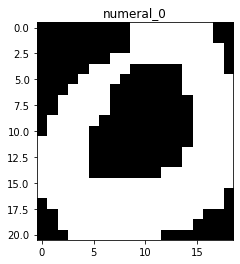

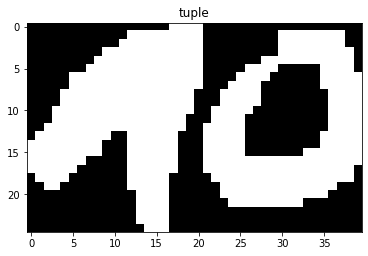

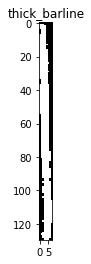

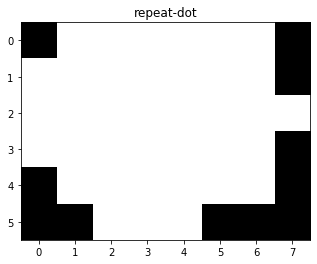

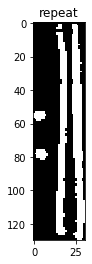

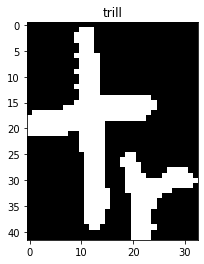

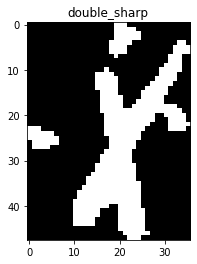

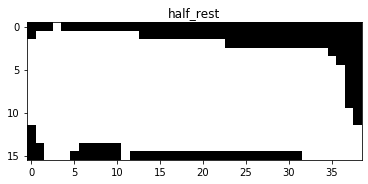

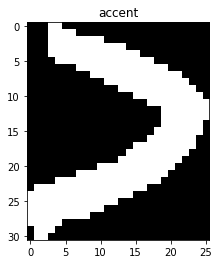

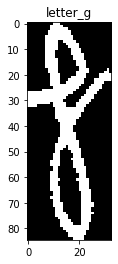

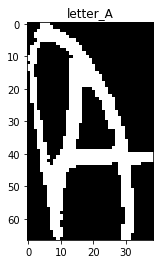

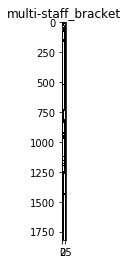

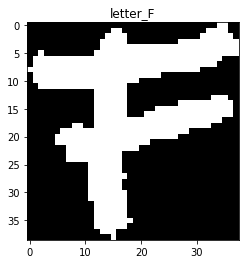

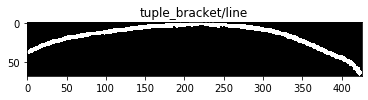

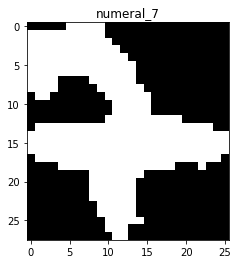

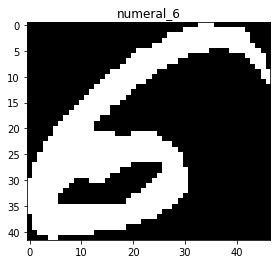

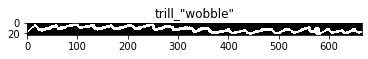

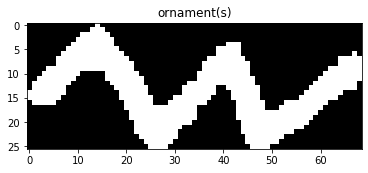

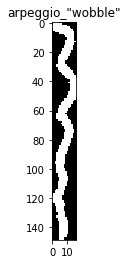

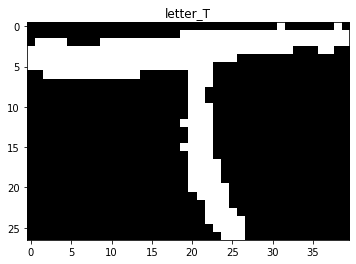

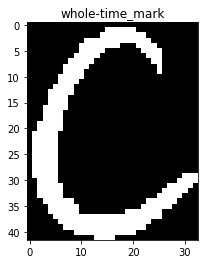

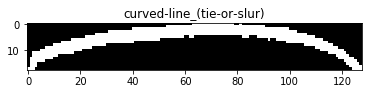

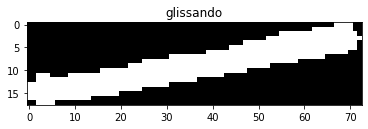

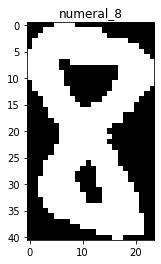

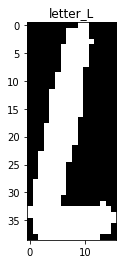

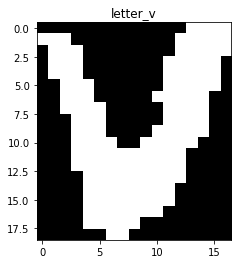

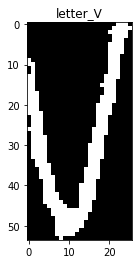

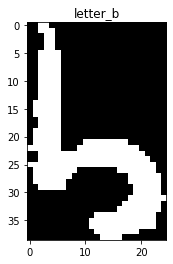

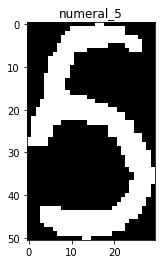

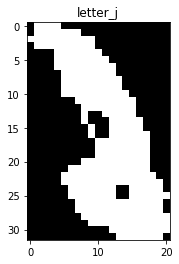

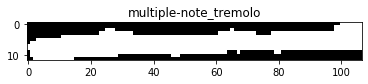

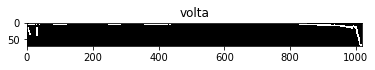

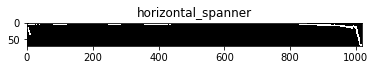

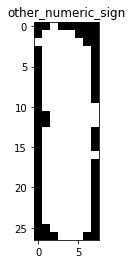

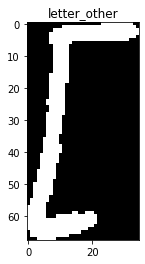

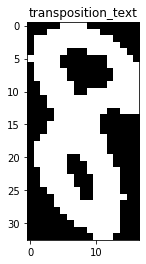

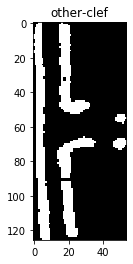

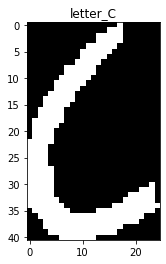

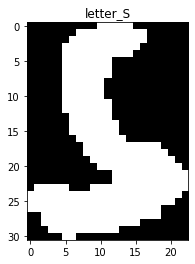

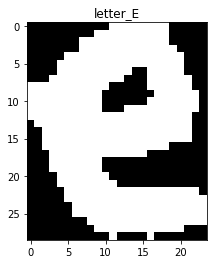

In [0]:
types = list();
for c in docs:
    for d in c: 
        if(d.clsname not in types):
            types.append(d.clsname)
            show_specific_mask(d.clsname)
        
        


# SIMPLE INSALLATION

# Below is the link for the documentation
https://buildmedia.readthedocs.org/media/pdf/muscimarker/latest/muscimarker.pdf

# DEFINITION OF SOME FUNCTIONS TO PRINT

In [0]:
# Bear in mind that the outlinks are integers, only valid within the same document.
# Therefore, we define a function per-document, not per-dataset.

def extract_notes_from_doc(cropobjects):
    """Finds all ``(full-notehead, stem)`` pairs that form
    quarter or half notes. Returns two lists of CropObject tuples:
    one for quarter notes, one of half notes.

    :returns: quarter_notes, half_notes
    """
    _cropobj_dict = {c.objid: c for c in cropobjects}

    notes = []
    for c in cropobjects:
        if (c.clsname == 'notehead-full') or (c.clsname == 'notehead-empty'):
            _has_stem = False
            _has_beam_or_flag = False
            stem_obj = None
            for o in c.outlinks:
                _o_obj = _cropobj_dict[o]
                if _o_obj.clsname == 'stem':
                    _has_stem = True
                    stem_obj = _o_obj
                elif _o_obj.clsname == 'beam':
                    _has_beam_or_flag = True
                elif _o_obj.clsname.endswith('flag'):
                    _has_beam_or_flag = True
            if _has_stem and (not _has_beam_or_flag):
                # We also need to check against quarter-note chords.
                # Stems only have inlinks from noteheads, so checking
                # for multiple inlinks will do the trick.
                if len(stem_obj.inlinks) == 1:
                    notes.append((c, stem_obj))

    quarter_notes = [(n, s) for n, s in notes if n.clsname == 'notehead-full']
    half_notes = [(n, s) for n, s in notes if n.clsname == 'notehead-empty']
    return quarter_notes, half_notes

qns_and_hns = [extract_notes_from_doc(cropobjects) for cropobjects in docs]

In [0]:
import itertools
qns = list(itertools.chain(*[qn for qn, hn in qns_and_hns]))
hns = list(itertools.chain(*[hn for qn, hn in qns_and_hns]))

len(qns), len(hns)

(4290, 1199)

In [0]:
def get_image(cropobjects, margin=1):
    """Paste the cropobjects' mask onto a shared canvas.
    There will be a given margin of background on the edges."""

    # Get the bounding box into which all the objects fit
    top = min([c.top for c in cropobjects])
    left = min([c.left for c in cropobjects])
    bottom = max([c.bottom for c in cropobjects])
    right = max([c.right for c in cropobjects])

    # Create the canvas onto which the masks will be pasted
    height = bottom - top + 2 * margin
    width = right - left + 2 * margin
    canvas = np.zeros((height, width), dtype='uint8')

    for c in cropobjects:
        # Get coordinates of upper left corner of the CropObject
        # relative to the canvas
        _pt = c.top - top + margin
        _pl = c.left - left + margin
        # We have to add the mask, so as not to overwrite
        if c.clsname =="staff_space": continue
        # previous nonzeros when symbol bounding boxes overlap.
        canvas[_pt:_pt+c.height, _pl:_pl+c.width] += c.mask

    canvas[canvas > 0] = 1
    return canvas

qn_images = [get_image(qn) for qn in qns]
hn_images = [get_image(hn) for hn in hns]

In [0]:
def show_mask(mask):
    plt.imshow(mask, cmap='gray', interpolation='nearest')
    plt.show()
def show_specific_mask(type):
    plt.title(type)
    for c in docs:
        flag = 0 
        for d in c:
            if(d.clsname == type): 
                show_mask(d.mask)
                flag = 1
                break
        if flag: break       
                
def show_masks(masks, row_length=5):
    n_masks = len(masks)
    n_rows = n_masks // row_length + 1
    n_cols = min(n_masks, row_length)
    fig = plt.figure()
    for i, mask in enumerate(masks):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(mask, cmap='gray', interpolation='nearest')
    # Let's remove the axis labels, they clutter the image.
    for ax in fig.axes:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_xticks([])
    plt.show()

# FIRST SUCCESSFUL PRINT

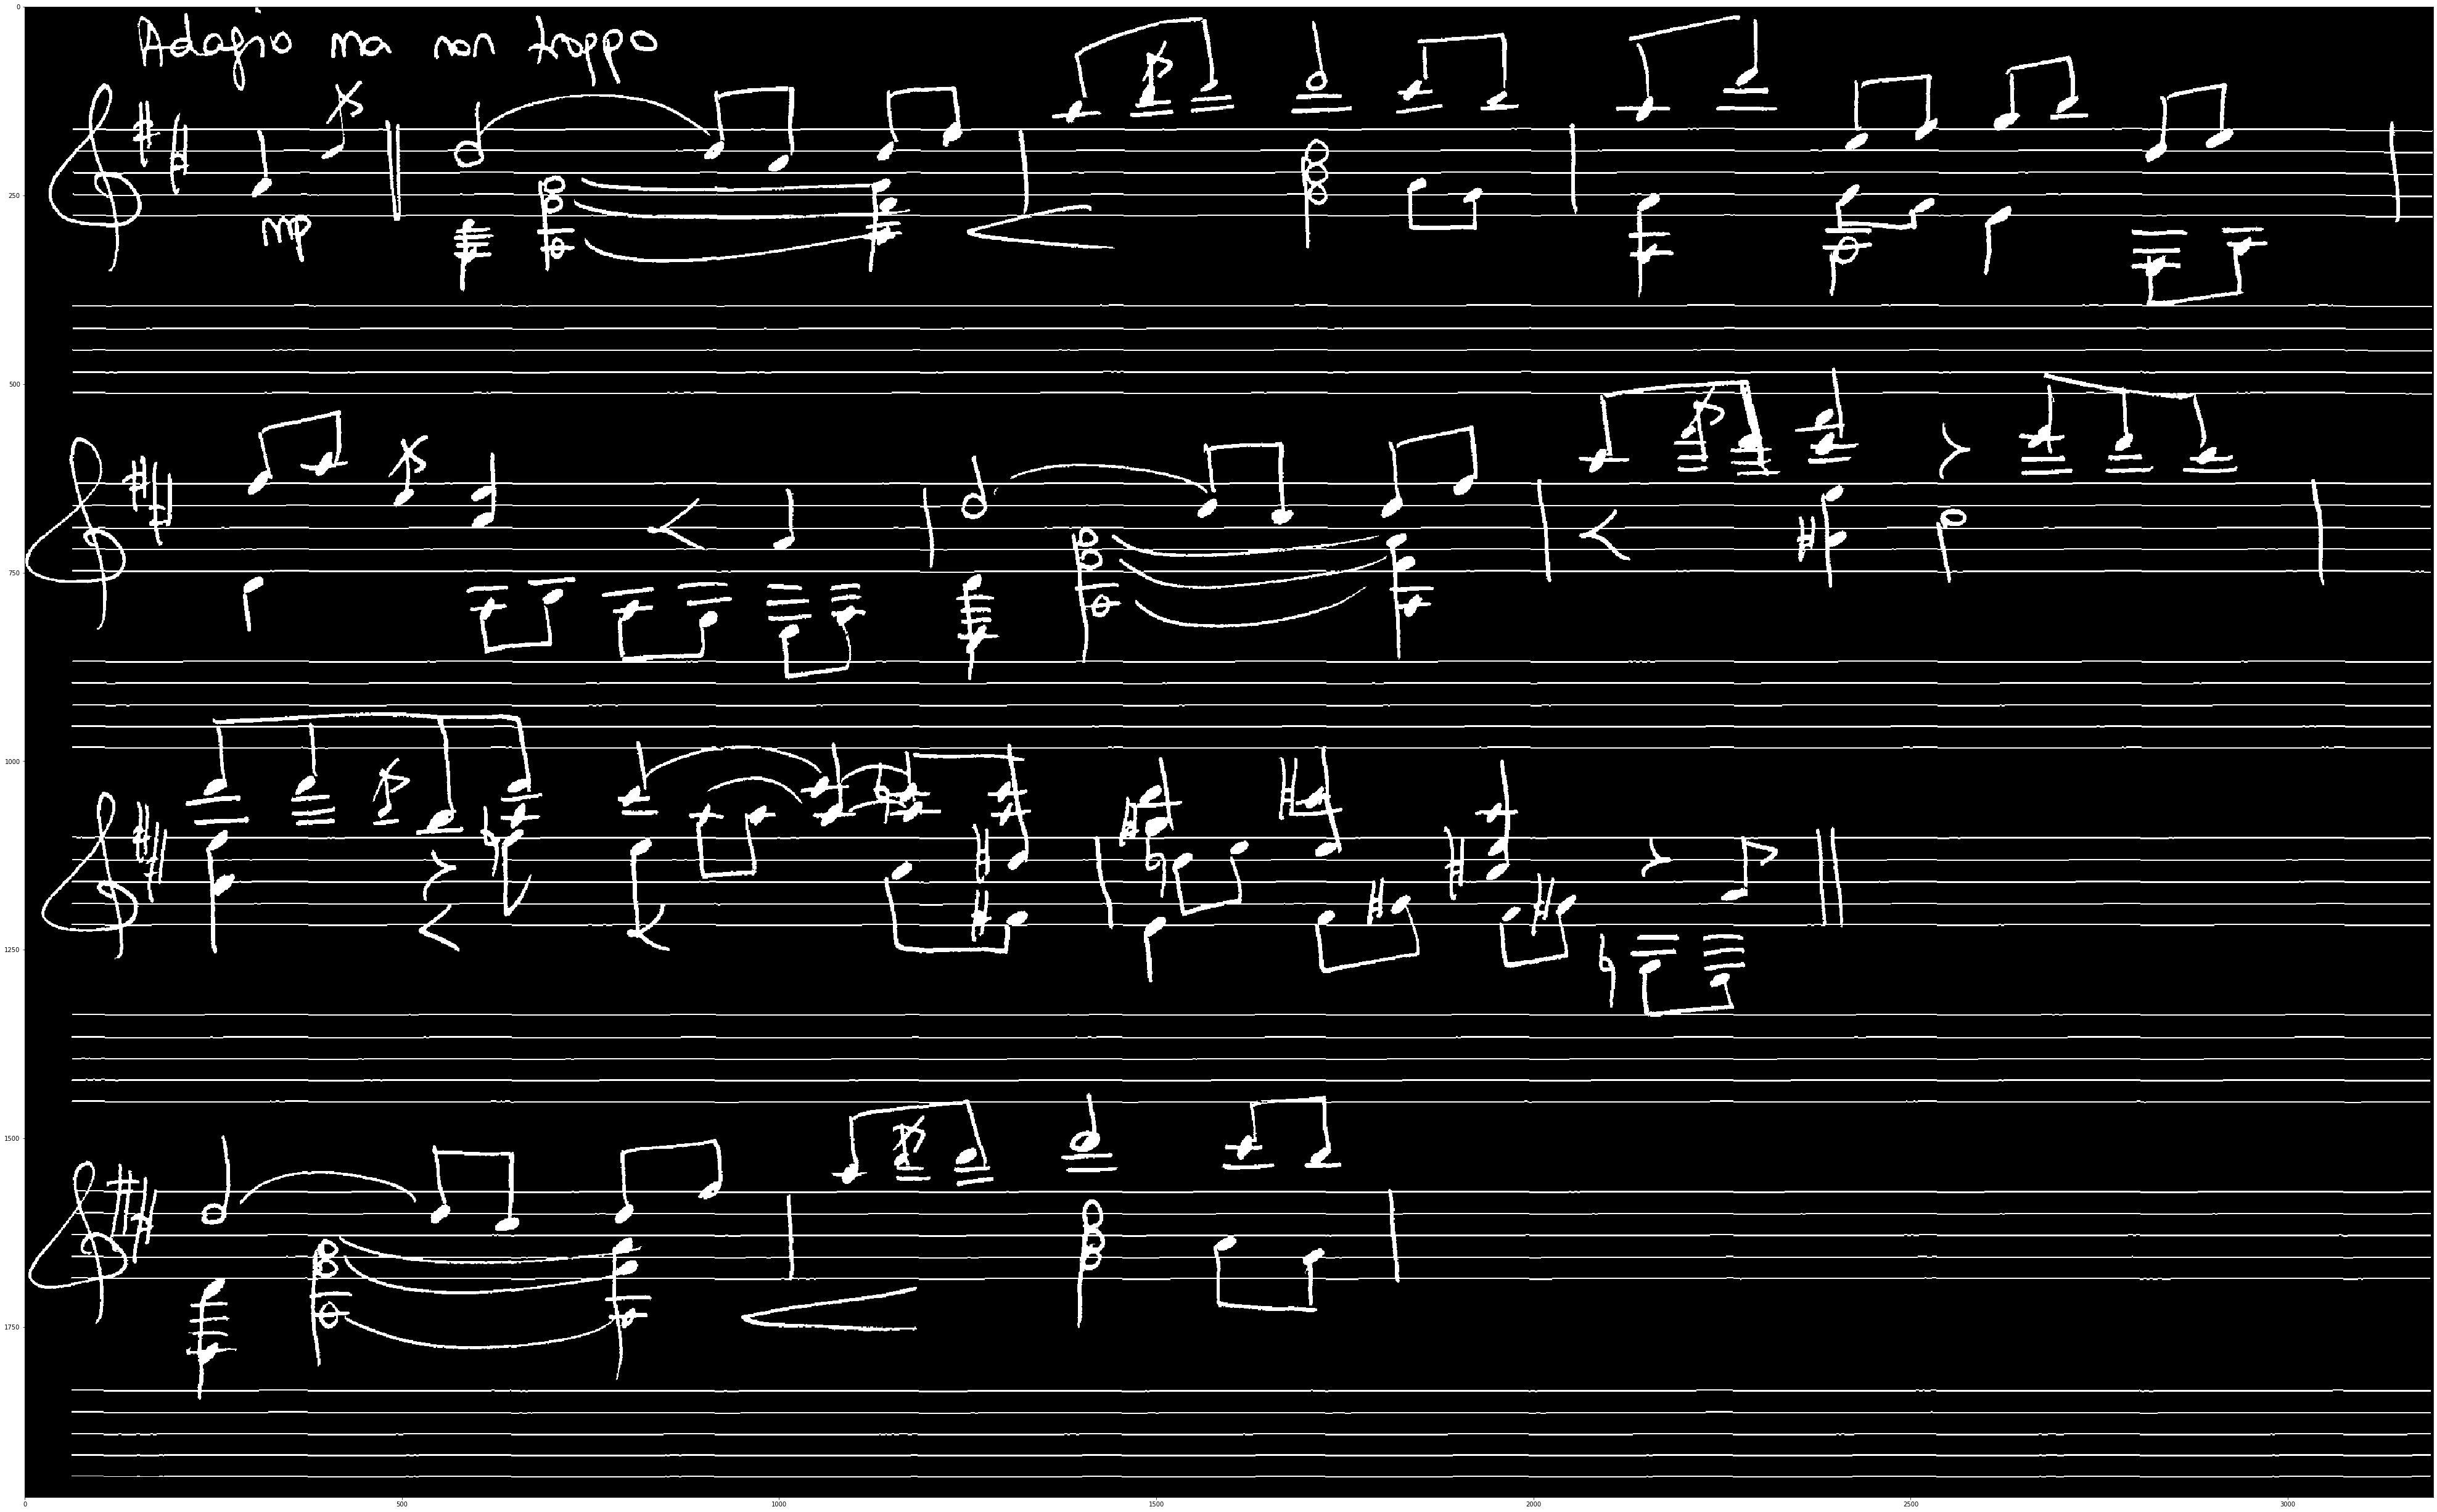

In [0]:

fig = plt.figure(figsize=(70, 70))
ax = fig.add_subplot(111)
ax.imshow(get_image(docs[7]),cmap='gray')
#plt.imshow()

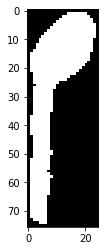

In [0]:
show_mask(qn_images[400])

In [0]:
types

['notehead-full',
 'notehead-empty',
 'stem',
 'ledger_line',
 '8th_flag',
 '16th_flag',
 'flat',
 'natural',
 'tie',
 'slur',
 '8th_rest',
 'quarter_rest',
 'c-clef',
 'thin_barline',
 'beam',
 'duration-dot',
 'letter_f',
 'dynamics_text',
 'letter_s',
 'letter_p',
 'letter_o',
 'letter_c',
 'letter_d',
 'letter_i',
 'letter_m',
 'other-dot',
 'other_text',
 'letter_r',
 'letter_t',
 'letter_e',
 'letter_n',
 'letter_u',
 'key_signature',
 'instrument_specific',
 'numeral_4',
 'numeral_2',
 'time_signature',
 'measure_separator',
 'dotted_horizontal_spanner',
 'staff_line',
 'staff_space',
 'staff',
 'sharp',
 '16th_rest',
 'grace-notehead-full',
 'g-clef',
 'f-clef',
 'staccato-dot',
 'multi-staff_brace',
 'grace_strikethrough',
 'staff_grouping',
 'numeral_3',
 'multi-measure_rest',
 'whole_rest',
 'tenuto',
 'letter_R',
 'tempo_text',
 'letter_a',
 'letter_l',
 'letter_M',
 'letter_x',
 'letter_P',
 'letter_z',
 'breath_mark',
 'hairpin-cresc.',
 'hairpin-decr.',
 'repeat_measure'

# Constructing the dataset

In [0]:
labels = list()
data = list()
maxheight = 0 
maxwidth = 0
for c in docs:
    for d in c: 
        labels.append(d.clsname)
        data.append(d.mask)
        if d.width > maxwidth: maxwidth = d.width
        if d.height > maxheight: maxheight = d.height  
len(data)            
            

101850

In [0]:
labels = np.array(["" for c in range(101850)],dtype=object)
data = np.ones(shape=(101850,100,100,1))
i=0
for c in docs:
    for d in c: 
        labels[i] = d.clsname
        data[i] = cv2.resize(d.mask,(100,100)).reshape(100,100,1)
        i = i +1

In [0]:
data.shape

(101850, 100, 100, 1)

In [0]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
labels = labels.reshape(len(labels), 1)
labels = onehot_encoder.fit_transform(labels)
print(onehot_encoder.categories_)
print(len(onehot_encoder.categories_))
labels.shape


[array(['16th_flag', '16th_rest', '8th_flag', '8th_rest', 'accent',
       'arpeggio_"wobble"', 'beam', 'breath_mark', 'c-clef',
       'curved-line_(tie-or-slur)', 'dotted_horizontal_spanner',
       'double_sharp', 'duration-dot', 'dynamics_text', 'f-clef',
       'fermata', 'flat', 'g-clef', 'glissando', 'grace-notehead-full',
       'grace_strikethrough', 'hairpin-cresc.', 'hairpin-decr.',
       'half_rest', 'horizontal_spanner', 'instrument_specific',
       'key_signature', 'ledger_line', 'letter_A', 'letter_C', 'letter_E',
       'letter_F', 'letter_L', 'letter_M', 'letter_P', 'letter_R',
       'letter_S', 'letter_T', 'letter_V', 'letter_a', 'letter_b',
       'letter_c', 'letter_d', 'letter_e', 'letter_f', 'letter_g',
       'letter_i', 'letter_j', 'letter_l', 'letter_m', 'letter_n',
       'letter_o', 'letter_other', 'letter_p', 'letter_r', 'letter_s',
       'letter_t', 'letter_u', 'letter_v', 'letter_x', 'letter_z',
       'measure_separator', 'multi-measure_rest', 'multi-

(101850, 110)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.33, random_state=42)

In [0]:
X_train.shape,y_train.shape

#X_train.T.reshape((68239,-100)).shape

((68239, 100, 100, 1), (68239, 110))

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(100,100,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(110, activation='softmax'))

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size = 128 )

Train on 68239 samples, validate on 33611 samples
Epoch 1/30
68239/68239 [==============================] - 1980s 29ms/step - loss: 0.6168 - acc: 0.8254 - val_loss: 0.6653 - val_acc: 0.8054
Epoch 2/30
68239/68239 [==============================] - 5173s 76ms/step - loss: 0.3175 - acc: 0.8954 - val_loss: 0.7530 - val_acc: 0.7991
Epoch 3/30
68239/68239 [==============================] - 1992s 29ms/step - loss: 0.2033 - acc: 0.9376 - val_loss: 0.7828 - val_acc: 0.8016
Epoch 4/30
68239/68239 [==============================] - 1948s 29ms/step - loss: 0.1607 - acc: 0.9512 - val_loss: 0.8709 - val_acc: 0.7953
Epoch 5/30
68239/68239 [==============================] - 1957s 29ms/step - loss: 0.1406 - acc: 0.9555 - val_loss: 0.8483 - val_acc: 0.7977
Epoch 6/30
54912/68239 [=======================>......] - ETA: 5:22 - loss: 0.1238 - acc: 0.9586

KeyboardInterrupt: 

In [0]:
print(model.predict(X_test[0:10])[1][6])

# 12 * 5

0.79780185


In [0]:
for i in range(len(y_test[1])) : 
    if(y_test[1][i]==1):
        print(i)
        

6


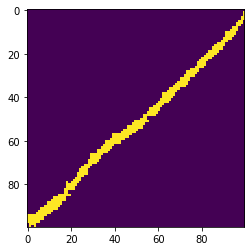

In [0]:
plt.imshow(X_test[1].reshape(100,100))

In [0]:
score = model.evaluate(X_test, y_test)

NameError: name 'model' is not defined

In [0]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


# Have Finished experimenting with easy dataset 
# Now time to get more serious


In [0]:
tmp = os.listdir("Corpus")
pandas.options.display.max_columns = 50


In [0]:
#One Hot Encode the Vocabulary File
vocabulary = pandas.read_csv("Corpus/vocab", header=None, prefix="")
vocabulary
vocabulary_one_hot = pandas.get_dummies(vocabulary)
vocabulary_one_hot

,0_barline,0_clef-C1,0_clef-C2,0_clef-C3,0_clef-C4,0_clef-C5,0_clef-F3,0_clef-F4,0_clef-F5,0_clef-G1,0_clef-G2,0_gracenote-A#3_eighth,0_gracenote-A#3_sixteenth,0_gracenote-A#4_eighth,0_gracenote-A#4_half,0_gracenote-A#4_quarter,0_gracenote-A#4_sixteenth,0_gracenote-A#4_thirty_second,0_gracenote-A#5_eighth,0_gracenote-A2_eighth,0_gracenote-A2_quarter,0_gracenote-A2_sixteenth,0_gracenote-A3_eighth,0_gracenote-A3_half,0_gracenote-A3_quarter,...,0_timeSignature-3/2,0_timeSignature-3/4,0_timeSignature-3/6,0_timeSignature-3/8,0_timeSignature-4/1,0_timeSignature-4/2,0_timeSignature-4/4,0_timeSignature-4/8,0_timeSignature-5/4,0_timeSignature-5/8,0_timeSignature-6/16,0_timeSignature-6/2,0_timeSignature-6/4,0_timeSignature-6/8,0_timeSignature-7/4,0_timeSignature-8/12,0_timeSignature-8/16,0_timeSignature-8/2,0_timeSignature-8/4,0_timeSignature-8/8,0_timeSignature-9/16,0_timeSignature-9/4,0_timeSignature-9/8,0_timeSignature-C,0_timeSignature-C/
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
#Function to turn the .semantic file into one hot encode
def extract(path):
    tmp = pandas.read_csv(path, header=None, sep = '\t',index_col=False, prefix=False).T.dropna()
    tmp_wid = len(vocabulary)
    tmp_len = len(tmp)
    instance = np.zeros((tmp_len,tmp_wid))
    for i in range(tmp_len):
        j = vocabulary_one_hot.columns.get_loc("0_"+tmp.iloc[i][0])
        
        instance[i][j] = 1
        
    return instance

In [0]:
#First Successfull Encoding
extract("Corpus/230006417-1_3_1/230006417-1_3_1.semantic")

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
#label = np.empty(len_tmp, dtype=object)
label = list()
k =0 
tmp = os.listdir("Corpus")
for i in tmp:
    if not os.path.isdir("Corpus/"+i): continue
    if not os.path.isfile("Corpus/"+i +"/"+i+".semantic"):
        continue
    label.append(extract("Corpus/"+i +"/"+i+".semantic"))

    

In [0]:
tmp = os.listdir("Corpus")
tmp[0]

'000104290-1_1_1'

In [0]:
import gc
gc.collect()

726

In [0]:
from keras.preprocessing.sequence import pad_sequences


In [0]:
padded = pad_sequences(label)

In [0]:
padded.shape

(87678, 58, 1781)

In [0]:
label = padded

In [0]:
gc.collect()

100

In [0]:
type(label)

numpy.ndarray

In [0]:
file = open("serial_labels.txt","wb")
np.save(file,label)

# Because of huge number of RAM the kernel was failing so I have desided to serialize the np array and serialize againing hoping to omit some intermittent computations

In [0]:
len_tmp =0
for i in tmp:
    if not os.path.isdir("Corpus/"+i): continue
    if not os.path.isfile("Corpus/"+i +"/"+i+".png"):
        continue
    len_tmp = len_tmp +1    
img = np.empty(len_tmp*568*58).reshape(len_tmp,58,568)
k = 0
for i in tmp:
    if not os.path.isdir("Corpus/"+i): continue
    if not os.path.isfile("Corpus/"+i +"/"+i+".png"):
        continue
    img[k] = cv2.resize(cv2.imread("Corpus/"+i +"/"+i+".png",0),(568,58))
    k = k+1

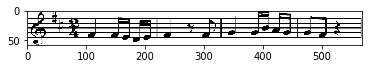

In [0]:
plt.imshow(img[len(img)-1],cmap="gray")
#Printing last image to see that it has all the alues

In [0]:

label = np.load("serial_labels.txt")


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


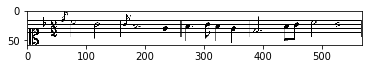

In [0]:
#First Successful Print
print(label[0])
plt.imshow(img[0],cmap="gray")

In [0]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, LSTM,MaxPooling2D, Input, Embedding
encoder_inputs = Input(shape=(58,568)) 
enc = LSTM(1781,return_sequences=True)(encoder_inputs)
model = Model(encoder_inputs,enc)


In [0]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(img, label,
          batch_size=128,
          epochs=4)

Epoch 1/4
87678/87678 [==============================] - 82709s 943ms/step - loss: nan - acc: 0.6188
Epoch 2/4
54912/87678 [=================>............] - ETA: 30:16 - loss: nan - acc: 0.6521

KeyboardInterrupt: 

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_87 (InputLayer)        (None, 58, 568)           0         
_________________________________________________________________
lstm_112 (LSTM)              (None, 58, 1781)          16741400  
Total params: 16,741,400
Trainable params: 16,741,400
Non-trainable params: 0
_________________________________________________________________


# There was a stagnation of 65% accuracy so I have stopped the model which was to be honest quite poorely designed

# Let's Test the model with handwritten dataset

In [0]:
im = cv2.resize(cv2.imread("Capitan/Normalized/10.jpg",0),(568,58))

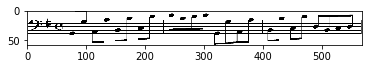

In [0]:
plt.imshow(img[100], cmap="gray")

In [0]:
x = model.predict(img[510].reshape(1,58,568))

In [0]:
def decode(x): 
    for i in range(58) :
        for j in range(1781):
            if(not np.isnan(x[0][i][j])):
                print(vocabulary_one_hot.columns[j])

In [0]:
decode(x)

In [0]:
np.isnan(x[0][1][100])

True

# No luck in predicting the model converges and results in all nans 

# I will try another more logically organized model

In [0]:
len_tmp =0
for i in tmp:
    if not os.path.isdir("Corpus/"+i): continue
    if not os.path.isfile("Corpus/"+i +"/"+i+".png"):
        continue
    len_tmp = len_tmp +1    
img = np.empty(len_tmp*568*62).reshape(len_tmp,62,568)
k = 0
for i in tmp:
    if not os.path.isdir("Corpus/"+i): continue
    if not os.path.isfile("Corpus/"+i +"/"+i+".png"):
        continue
    img[k] = cv2.resize(cv2.imread("Corpus/"+i +"/"+i+".png",0),(568,62))
    k = k+1

In [0]:
label = np.load("serial_labels.txt")

In [0]:
from keras.models import Sequential, Model
import keras.backend
from keras.layers import Dense, Conv2D, Flatten, LSTM,MaxPooling2D, Input, Embedding, Permute
encoder_inputs = Input(shape=(62,568)) 
res_in = keras.layers.core.Reshape((62,568,1))(encoder_inputs)
conv1 = Conv2D(kernel_size=3, filters=64)(res_in)
max1 = MaxPooling2D(2)(conv1)
conv2 = Conv2D(kernel_size=3, filters=16)(max1)
conv3 = Conv2D(kernel_size=3, filters=1)(conv2)
res = keras.layers.core.Reshape((26,279))(conv3)
#pr = Permute((2, 1))(res)
lst = LSTM(279,input_shape=(26,1),return_sequences=True)(res)
dn = Dense(58)(lst)
pr = Permute((2, 1))(dn)
#dec = LSTM(58, input_shape=(1,26), return_sequences=True)(dn)
out = Dense(1781,activation="softmax")(pr)
#de
model2 = Model(encoder_inputs,out)
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 62, 568)           0         
_________________________________________________________________
reshape_46 (Reshape)         (None, 62, 568, 1)        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 60, 566, 64)       640       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 30, 283, 64)       0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 28, 281, 16)       9232      
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 26, 279, 1)        145       
_________________________________________________________________
reshape_47 (Reshape)         (None, 26, 279)           0         
__________

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    img, label, test_size=0.33, random_state=42)

2110

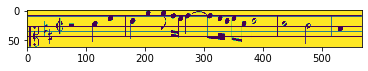

In [0]:
import gc
plt.imshow(X_train[1])
gc.collect()

In [0]:
model2.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
model2.fit(X_train, y_train,
          batch_size=256,
          epochs=5)

Epoch 1/5
58744/58744 [==============================] - 2023s 34ms/step - loss: 2.0393 - acc: 0.5907
Epoch 2/5
58744/58744 [==============================] - 1985s 34ms/step - loss: 1.9669 - acc: 0.6408
Epoch 3/5
58744/58744 [==============================] - 1951s 33ms/step - loss: 1.9666 - acc: 0.6410
Epoch 4/5
58744/58744 [==============================] - 1936s 33ms/step - loss: 1.9662 - acc: 0.6361
Epoch 5/5
58744/58744 [==============================] - 1925s 33ms/step - loss: 1.9255 - acc: 0.4808


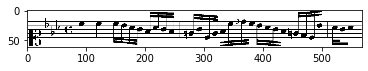

In [0]:
plt.imshow(X_test[0],cmap='gray')
y = model2.predict(X_test[0].reshape(1,62,568))

In [0]:

def decode(x):
    x = x.reshape(58,1781)
    for i in range(58):
        j=np.max(x[i])
        for k in range(1781):
             if(x[i][k]==j):
                print(vocabulary_one_hot.columns[k])

In [0]:
decode(y)

0_barline
0_barline
0_barline
0_barline
0_clef-G2
0_clef-G2
0_clef-G2
0_clef-G2
0_clef-G2
0_clef-G2
0_clef-G2
0_clef-G2
0_clef-G2
0_clef-G2
0_clef-G2
0_clef-G2
0_clef-G2
0_clef-G2
0_clef-G2
0_clef-G2
0_clef-G2
0_clef-G2
0_clef-G2
0_clef-G2
0_clef-G2
0_clef-G2
0_clef-G2
0_clef-G2
0_clef-G2
0_clef-G2
0_clef-G2
0_clef-G2
0_clef-G2
0_barline
0_barline
0_barline
0_barline
0_barline
0_barline
0_barline
0_barline
0_barline
0_barline
0_barline
0_barline
0_barline
0_barline
0_barline
0_barline
0_barline
0_barline
0_barline
0_barline
0_barline
0_barline
0_barline
0_barline
0_barline


In [0]:
decode(y_test[0])

0_barline
0_clef-C1
0_clef-C2
0_clef-C3
0_clef-C4
0_clef-C5
0_clef-F3
0_clef-F4
0_clef-F5
0_clef-G1
0_clef-G2
0_gracenote-A#3_eighth
0_gracenote-A#3_sixteenth
0_gracenote-A#4_eighth
0_gracenote-A#4_half
0_gracenote-A#4_quarter
0_gracenote-A#4_sixteenth
0_gracenote-A#4_thirty_second
0_gracenote-A#5_eighth
0_gracenote-A2_eighth
0_gracenote-A2_quarter
0_gracenote-A2_sixteenth
0_gracenote-A3_eighth
0_gracenote-A3_half
0_gracenote-A3_quarter
0_gracenote-A3_sixteenth
0_gracenote-A3_thirty_second
0_gracenote-A4_eighth
0_gracenote-A4_half
0_gracenote-A4_quarter
0_gracenote-A4_sixteenth
0_gracenote-A4_thirty_second
0_gracenote-A5_eighth
0_gracenote-A5_quarter
0_gracenote-A5_sixteenth
0_gracenote-A5_sixteenth.
0_gracenote-A5_thirty_second
0_gracenote-Ab3_double_whole
0_gracenote-Ab3_eighth
0_gracenote-Ab3_sixteenth
0_gracenote-Ab3_thirty_second
0_gracenote-Ab4_eighth
0_gracenote-Ab4_half
0_gracenote-Ab4_quarter
0_gracenote-Ab4_sixteenth
0_gracenote-Ab4_thirty_second
0_gracenote-Ab5_eighth
0_grac

0_note-Bb4_whole._fermata
0_note-Bb4_whole_fermata
0_note-Bb5_double_whole
0_note-Bb5_eighth
0_note-Bb5_eighth.
0_note-Bb5_eighth..
0_note-Bb5_half
0_note-Bb5_half.
0_note-Bb5_half_fermata
0_note-Bb5_quarter
0_note-Bb5_quarter.
0_note-Bb5_quarter..
0_note-Bb5_quarter_fermata
0_note-Bb5_sixteenth
0_note-Bb5_sixteenth.
0_note-Bb5_sixty_fourth
0_note-Bb5_thirty_second
0_note-Bb5_thirty_second.
0_note-Bb5_whole
0_note-Bb5_whole.
0_note-Bb5_whole_fermata
0_note-C#2_eighth
0_note-C#2_eighth.
0_note-C#2_quarter
0_note-C#2_quarter.
0_note-C#2_sixteenth
0_note-C#2_whole
0_note-C#3_double_whole
0_note-C#3_eighth
0_note-C#3_eighth.
0_note-C#3_half
0_note-C#3_half.
0_note-C#3_quarter
0_note-C#3_quarter.
0_note-C#3_sixteenth
0_note-C#3_sixteenth.
0_note-C#3_thirty_second
0_note-C#3_whole
0_note-C#4_eighth
0_note-C#4_eighth.
0_note-C#4_eighth..
0_note-C#4_eighth_fermata
0_note-C#4_half
0_note-C#4_half.
0_note-C#4_half_fermata
0_note-C#4_quadruple_whole_fermata
0_note-C#4_quarter
0_note-C#4_quarter.


0_note-D5_whole._fermata
0_note-D5_whole_fermata
0_note-D6_eighth
0_note-D6_eighth.
0_note-D6_eighth..
0_note-D6_eighth_fermata
0_note-D6_half
0_note-D6_half.
0_note-D6_half..
0_note-D6_half_fermata
0_note-D6_quarter
0_note-D6_quarter.
0_note-D6_quarter..
0_note-D6_quarter._fermata
0_note-D6_quarter_fermata
0_note-D6_sixteenth
0_note-D6_sixteenth.
0_note-D6_sixty_fourth
0_note-D6_thirty_second
0_note-D6_whole
0_note-D6_whole.
0_note-D6_whole_fermata
0_note-Db3_eighth
0_note-Db3_eighth.
0_note-Db3_half
0_note-Db3_half.
0_note-Db3_quarter
0_note-Db3_quarter.
0_note-Db3_sixteenth
0_note-Db3_thirty_second
0_note-Db4_double_whole
0_note-Db4_eighth
0_note-Db4_eighth.
0_note-Db4_eighth..
0_note-Db4_half
0_note-Db4_half.
0_note-Db4_quarter
0_note-Db4_quarter.
0_note-Db4_sixteenth
0_note-Db4_sixteenth.
0_note-Db4_thirty_second
0_note-Db4_whole
0_note-Db4_whole._fermata
0_note-Db5_double_whole
0_note-Db5_eighth
0_note-Db5_eighth.
0_note-Db5_eighth..
0_note-Db5_half
0_note-Db5_half.
0_note-Db5_ha

0_note-E4_eighth
0_note-E4_eighth.
0_note-E4_eighth..
0_note-E4_eighth_fermata
0_note-E4_half
0_note-E4_half.
0_note-E4_half._fermata
0_note-E4_half_fermata
0_note-E4_quadruple_whole
0_note-E4_quadruple_whole.
0_note-E4_quadruple_whole_fermata
0_note-E4_quarter
0_note-E4_quarter.
0_note-E4_quarter..
0_note-E4_quarter._fermata
0_note-E4_quarter_fermata
0_note-E4_sixteenth
0_note-E4_sixteenth.
0_note-E4_sixty_fourth
0_note-E4_thirty_second
0_note-E4_whole
0_note-E4_whole.
0_note-E4_whole_fermata
0_note-E5_double_whole
0_note-E5_double_whole.
0_note-E5_double_whole_fermata
0_note-E5_eighth
0_note-E5_eighth.
0_note-E5_eighth..
0_note-E5_eighth_fermata
0_note-E5_half
0_note-E5_half.
0_note-E5_half..
0_note-E5_half._fermata
0_note-E5_half_fermata
0_note-E5_quadruple_whole_fermata
0_note-E5_quarter
0_note-E5_quarter.
0_note-E5_quarter..
0_note-E5_quarter._fermata
0_note-E5_quarter_fermata
0_note-E5_sixteenth
0_note-E5_sixteenth.
0_note-E5_sixteenth_fermata
0_note-E5_sixty_fourth
0_note-E5_thi

0_note-F#3_half.
0_note-F#3_half_fermata
0_note-F#3_quarter
0_note-F#3_quarter.
0_note-F#3_quarter_fermata
0_note-F#3_sixteenth
0_note-F#3_sixteenth.
0_note-F#3_sixty_fourth
0_note-F#3_thirty_second
0_note-F#3_whole
0_note-F#3_whole.
0_note-F#4_double_whole
0_note-F#4_double_whole_fermata
0_note-F#4_eighth
0_note-F#4_eighth.
0_note-F#4_eighth..
0_note-F#4_eighth_fermata
0_note-F#4_half
0_note-F#4_half.
0_note-F#4_half_fermata
0_note-F#4_quadruple_whole_fermata
0_note-F#4_quarter
0_note-F#4_quarter.
0_note-F#4_quarter..
0_note-F#4_quarter._fermata
0_note-F#4_quarter_fermata
0_note-F#4_sixteenth
0_note-F#4_sixteenth.
0_note-F#4_sixty_fourth
0_note-F#4_thirty_second
0_note-F#4_thirty_second.
0_note-F#4_whole
0_note-F#4_whole.
0_note-F#4_whole._fermata
0_note-F#4_whole_fermata
0_note-F#5_double_whole
0_note-F#5_eighth
0_note-F#5_eighth.
0_note-F#5_eighth..
0_note-F#5_eighth._fermata
0_note-F#5_eighth_fermata
0_note-F#5_half
0_note-F#5_half.
0_note-F#5_half._fermata
0_note-F#5_half_fermata


0_note-F#6_sixteenth
0_note-F#6_thirty_second
0_note-F#6_whole
0_note-F2_double_whole
0_note-F2_double_whole.
0_note-F2_double_whole_fermata
0_note-F2_eighth
0_note-F2_eighth.
0_note-F2_half
0_note-F2_half.
0_note-F2_half_fermata
0_note-F2_quadruple_whole
0_note-F2_quarter
0_note-F2_quarter.
0_note-F2_quarter..
0_note-F2_sixteenth
0_note-F2_sixteenth.
0_note-F2_thirty_second
0_note-F2_whole
0_note-F2_whole.
0_note-F3_double_whole
0_note-F3_double_whole.
0_note-F3_double_whole_fermata
0_note-F3_eighth
0_note-F3_eighth.
0_note-F3_half
0_note-F3_half.
0_note-F3_half_fermata
0_note-F3_quadruple_whole
0_note-F3_quarter
0_note-F3_quarter.
0_note-F3_quarter..
0_note-F3_sixteenth
0_note-F3_sixteenth.
0_note-F3_thirty_second
0_note-F3_whole
0_note-F3_whole.
0_note-F3_whole_fermata
0_note-F4_double_whole
0_note-F4_double_whole.
0_note-F4_double_whole_fermata
0_note-F4_eighth
0_note-F4_eighth.
0_note-F4_eighth..
0_note-F4_eighth_fermata
0_note-F4_half
0_note-F4_half.
0_note-F4_half..
0_note-F4_ha

0_timeSignature-2/1
0_timeSignature-2/2
0_timeSignature-2/3
0_timeSignature-2/4
0_timeSignature-2/48
0_timeSignature-2/8
0_timeSignature-24/16
0_timeSignature-3/1
0_timeSignature-3/2
0_timeSignature-3/4
0_timeSignature-3/6
0_timeSignature-3/8
0_timeSignature-4/1
0_timeSignature-4/2
0_timeSignature-4/4
0_timeSignature-4/8
0_timeSignature-5/4
0_timeSignature-5/8
0_timeSignature-6/16
0_timeSignature-6/2
0_timeSignature-6/4
0_timeSignature-6/8
0_timeSignature-7/4
0_timeSignature-8/12
0_timeSignature-8/16
0_timeSignature-8/2
0_timeSignature-8/4
0_timeSignature-8/8
0_timeSignature-9/16
0_timeSignature-9/4
0_timeSignature-9/8
0_timeSignature-C
0_timeSignature-C/
0_barline
0_clef-C1
0_clef-C2
0_clef-C3
0_clef-C4
0_clef-C5
0_clef-F3
0_clef-F4
0_clef-F5
0_clef-G1
0_clef-G2
0_gracenote-A#3_eighth
0_gracenote-A#3_sixteenth
0_gracenote-A#4_eighth
0_gracenote-A#4_half
0_gracenote-A#4_quarter
0_gracenote-A#4_sixteenth
0_gracenote-A#4_thirty_second
0_gracenote-A#5_eighth
0_gracenote-A2_eighth
0_gracen

0_barline
0_clef-C1
0_clef-C2
0_clef-C3
0_clef-C4
0_clef-C5
0_clef-F3
0_clef-F4
0_clef-F5
0_clef-G1
0_clef-G2
0_gracenote-A#3_eighth
0_gracenote-A#3_sixteenth
0_gracenote-A#4_eighth
0_gracenote-A#4_half
0_gracenote-A#4_quarter
0_gracenote-A#4_sixteenth
0_gracenote-A#4_thirty_second
0_gracenote-A#5_eighth
0_gracenote-A2_eighth
0_gracenote-A2_quarter
0_gracenote-A2_sixteenth
0_gracenote-A3_eighth
0_gracenote-A3_half
0_gracenote-A3_quarter
0_gracenote-A3_sixteenth
0_gracenote-A3_thirty_second
0_gracenote-A4_eighth
0_gracenote-A4_half
0_gracenote-A4_quarter
0_gracenote-A4_sixteenth
0_gracenote-A4_thirty_second
0_gracenote-A5_eighth
0_gracenote-A5_quarter
0_gracenote-A5_sixteenth
0_gracenote-A5_sixteenth.
0_gracenote-A5_thirty_second
0_gracenote-Ab3_double_whole
0_gracenote-Ab3_eighth
0_gracenote-Ab3_sixteenth
0_gracenote-Ab3_thirty_second
0_gracenote-Ab4_eighth
0_gracenote-Ab4_half
0_gracenote-Ab4_quarter
0_gracenote-Ab4_sixteenth
0_gracenote-Ab4_thirty_second
0_gracenote-Ab5_eighth
0_grac

0_multirest-39
0_multirest-4
0_multirest-40
0_multirest-41
0_multirest-42
0_multirest-43
0_multirest-44
0_multirest-45
0_multirest-46
0_multirest-47
0_multirest-48
0_multirest-49
0_multirest-5
0_multirest-50
0_multirest-51
0_multirest-52
0_multirest-53
0_multirest-54
0_multirest-55
0_multirest-56
0_multirest-57
0_multirest-58
0_multirest-59
0_multirest-6
0_multirest-60
0_multirest-63
0_multirest-64
0_multirest-65
0_multirest-66
0_multirest-67
0_multirest-68
0_multirest-69
0_multirest-7
0_multirest-70
0_multirest-71
0_multirest-72
0_multirest-73
0_multirest-76
0_multirest-77
0_multirest-79
0_multirest-8
0_multirest-80
0_multirest-81
0_multirest-88
0_multirest-89
0_multirest-9
0_multirest-91
0_multirest-94
0_multirest-96
0_multirest-98
0_multirest-99
0_note-A#2_eighth
0_note-A#2_half
0_note-A#2_quarter
0_note-A#2_quarter.
0_note-A#2_sixteenth
0_note-A#2_sixteenth.
0_note-A#2_whole
0_note-A#3_eighth
0_note-A#3_eighth.
0_note-A#3_half
0_note-A#3_half.
0_note-A#3_half_fermata
0_note-A#3_qua

0_note-B#3_half
0_note-B#3_half.
0_note-B#3_quarter
0_note-B#3_quarter.
0_note-B#3_sixteenth
0_note-B#3_thirty_second
0_note-B#3_whole
0_note-B#4_double_whole
0_note-B#4_double_whole_fermata
0_note-B#4_eighth
0_note-B#4_eighth.
0_note-B#4_half
0_note-B#4_half.
0_note-B#4_quarter
0_note-B#4_quarter.
0_note-B#4_sixteenth
0_note-B#4_sixteenth.
0_note-B#4_thirty_second
0_note-B#4_whole
0_note-B#4_whole.
0_note-B#5_eighth
0_note-B#5_quarter
0_note-B#5_sixteenth
0_note-B1_quarter
0_note-B2_double_whole
0_note-B2_eighth
0_note-B2_eighth.
0_note-B2_half
0_note-B2_half.
0_note-B2_half_fermata
0_note-B2_quarter
0_note-B2_quarter.
0_note-B2_sixteenth
0_note-B2_sixteenth.
0_note-B2_sixty_fourth
0_note-B2_thirty_second
0_note-B2_whole
0_note-B2_whole.
0_note-B3_double_whole
0_note-B3_double_whole.
0_note-B3_double_whole_fermata
0_note-B3_eighth
0_note-B3_eighth.
0_note-B3_eighth_fermata
0_note-B3_half
0_note-B3_half.
0_note-B3_half_fermata
0_note-B3_quarter
0_note-B3_quarter.
0_note-B3_quarter..
0_

0_note-F#4_whole._fermata
0_note-F#4_whole_fermata
0_note-F#5_double_whole
0_note-F#5_eighth
0_note-F#5_eighth.
0_note-F#5_eighth..
0_note-F#5_eighth._fermata
0_note-F#5_eighth_fermata
0_note-F#5_half
0_note-F#5_half.
0_note-F#5_half._fermata
0_note-F#5_half_fermata
0_note-F#5_quarter
0_note-F#5_quarter.
0_note-F#5_quarter..
0_note-F#5_quarter._fermata
0_note-F#5_quarter_fermata
0_note-F#5_sixteenth
0_note-F#5_sixteenth.
0_note-F#5_sixty_fourth
0_note-F#5_thirty_second
0_note-F#5_whole
0_note-F#5_whole.
0_note-F#5_whole_fermata
0_note-F#6_eighth
0_note-F#6_eighth.
0_note-F#6_half
0_note-F#6_half.
0_note-F#6_quarter
0_note-F#6_quarter.
0_note-F#6_sixteenth
0_note-F#6_thirty_second
0_note-F#6_whole
0_note-F2_double_whole
0_note-F2_double_whole.
0_note-F2_double_whole_fermata
0_note-F2_eighth
0_note-F2_eighth.
0_note-F2_half
0_note-F2_half.
0_note-F2_half_fermata
0_note-F2_quadruple_whole
0_note-F2_quarter
0_note-F2_quarter.
0_note-F2_quarter..
0_note-F2_sixteenth
0_note-F2_sixteenth.
0_n

0_gracenote-Db5_quarter
0_gracenote-Db5_sixteenth
0_gracenote-Db5_thirty_second
0_gracenote-E#4_eighth
0_gracenote-E#4_sixteenth
0_gracenote-E#5_eighth
0_gracenote-E#5_quarter
0_gracenote-E#5_sixteenth
0_gracenote-E3_eighth
0_gracenote-E3_quarter
0_gracenote-E3_sixteenth
0_gracenote-E4_eighth
0_gracenote-E4_quarter
0_gracenote-E4_sixteenth
0_gracenote-E4_thirty_second
0_gracenote-E5_eighth
0_gracenote-E5_half
0_gracenote-E5_quarter
0_gracenote-E5_sixteenth
0_gracenote-E5_thirty_second
0_gracenote-Eb3_eighth
0_gracenote-Eb3_quarter
0_gracenote-Eb3_sixteenth
0_gracenote-Eb4_eighth
0_gracenote-Eb4_quarter
0_gracenote-Eb4_sixteenth
0_gracenote-Eb4_thirty_second
0_gracenote-Eb5_eighth
0_gracenote-Eb5_quarter
0_gracenote-Eb5_quarter.
0_gracenote-Eb5_sixteenth
0_gracenote-Eb5_thirty_second
0_gracenote-F#2_quarter
0_gracenote-F#3_eighth
0_gracenote-F#3_quarter
0_gracenote-F#3_sixteenth
0_gracenote-F#4_eighth
0_gracenote-F#4_quarter
0_gracenote-F#4_sixteenth
0_gracenote-F#4_thirty_second
0_grac

0_note-D3_double_whole_fermata
0_note-D3_eighth
0_note-D3_eighth.
0_note-D3_eighth_fermata
0_note-D3_half
0_note-D3_half.
0_note-D3_half_fermata
0_note-D3_quadruple_whole
0_note-D3_quadruple_whole_fermata
0_note-D3_quarter
0_note-D3_quarter.
0_note-D3_quarter..
0_note-D3_quarter._fermata
0_note-D3_quarter_fermata
0_note-D3_sixteenth
0_note-D3_sixteenth.
0_note-D3_sixty_fourth
0_note-D3_thirty_second
0_note-D3_whole
0_note-D3_whole.
0_note-D3_whole_fermata
0_note-D4_double_whole
0_note-D4_double_whole.
0_note-D4_double_whole_fermata
0_note-D4_eighth
0_note-D4_eighth.
0_note-D4_eighth..
0_note-D4_eighth._fermata
0_note-D4_eighth_fermata
0_note-D4_half
0_note-D4_half.
0_note-D4_half._fermata
0_note-D4_half_fermata
0_note-D4_hundred_twenty_eighth
0_note-D4_quadruple_whole
0_note-D4_quadruple_whole_fermata
0_note-D4_quarter
0_note-D4_quarter.
0_note-D4_quarter..
0_note-D4_quarter.._fermata
0_note-D4_quarter._fermata
0_note-D4_quarter_fermata
0_note-D4_sixteenth
0_note-D4_sixteenth.
0_note-D

0_rest-eighth._fermata
0_rest-eighth_fermata
0_rest-half
0_rest-half.
0_rest-half._fermata
0_rest-half_fermata
0_rest-quadruple_whole
0_rest-quarter
0_rest-quarter.
0_rest-quarter..
0_rest-quarter.._fermata
0_rest-quarter._fermata
0_rest-quarter_fermata
0_rest-sixteenth
0_rest-sixteenth.
0_rest-sixteenth_fermata
0_rest-sixty_fourth
0_rest-thirty_second
0_rest-whole
0_rest-whole.
0_rest-whole_fermata
0_tie
0_timeSignature-1/2
0_timeSignature-1/4
0_timeSignature-11/4
0_timeSignature-12/16
0_timeSignature-12/4
0_timeSignature-12/8
0_timeSignature-2/1
0_timeSignature-2/2
0_timeSignature-2/3
0_timeSignature-2/4
0_timeSignature-2/48
0_timeSignature-2/8
0_timeSignature-24/16
0_timeSignature-3/1
0_timeSignature-3/2
0_timeSignature-3/4
0_timeSignature-3/6
0_timeSignature-3/8
0_timeSignature-4/1
0_timeSignature-4/2
0_timeSignature-4/4
0_timeSignature-4/8
0_timeSignature-5/4
0_timeSignature-5/8
0_timeSignature-6/16
0_timeSignature-6/2
0_timeSignature-6/4
0_timeSignature-6/8
0_timeSignature-7/4
0_

0_note-A#4_quarter_fermata
0_note-A#4_sixteenth
0_note-A#4_sixteenth.
0_note-A#4_thirty_second
0_note-A#4_whole
0_note-A#4_whole.
0_note-A#5_eighth
0_note-A#5_eighth.
0_note-A#5_half
0_note-A#5_half.
0_note-A#5_quarter
0_note-A#5_quarter.
0_note-A#5_sixteenth
0_note-A#5_sixteenth.
0_note-A#5_thirty_second
0_note-A1_sixteenth
0_note-A2_double_whole
0_note-A2_double_whole.
0_note-A2_double_whole_fermata
0_note-A2_eighth
0_note-A2_eighth.
0_note-A2_half
0_note-A2_half.
0_note-A2_half_fermata
0_note-A2_quadruple_whole
0_note-A2_quadruple_whole_fermata
0_note-A2_quarter
0_note-A2_quarter.
0_note-A2_quarter_fermata
0_note-A2_sixteenth
0_note-A2_sixteenth.
0_note-A2_sixty_fourth
0_note-A2_thirty_second
0_note-A2_whole
0_note-A2_whole.
0_note-A2_whole_fermata
0_note-A3_double_whole
0_note-A3_double_whole.
0_note-A3_double_whole_fermata
0_note-A3_eighth
0_note-A3_eighth.
0_note-A3_eighth..
0_note-A3_eighth._fermata
0_note-A3_eighth_fermata
0_note-A3_half
0_note-A3_half.
0_note-A3_half._fermata


0_note-F4_eighth_fermata
0_note-F4_half
0_note-F4_half.
0_note-F4_half..
0_note-F4_half._fermata
0_note-F4_half_fermata
0_note-F4_hundred_twenty_eighth
0_note-F4_quadruple_whole
0_note-F4_quadruple_whole.
0_note-F4_quadruple_whole_fermata
0_note-F4_quarter
0_note-F4_quarter.
0_note-F4_quarter..
0_note-F4_quarter._fermata
0_note-F4_quarter_fermata
0_note-F4_sixteenth
0_note-F4_sixteenth.
0_note-F4_sixty_fourth
0_note-F4_thirty_second
0_note-F4_whole
0_note-F4_whole.
0_note-F4_whole_fermata
0_note-F5_double_whole
0_note-F5_eighth
0_note-F5_eighth.
0_note-F5_eighth..
0_note-F5_half
0_note-F5_half.
0_note-F5_half._fermata
0_note-F5_half_fermata
0_note-F5_quarter
0_note-F5_quarter.
0_note-F5_quarter..
0_note-F5_quarter._fermata
0_note-F5_quarter_fermata
0_note-F5_sixteenth
0_note-F5_sixteenth.
0_note-F5_sixty_fourth
0_note-F5_thirty_second
0_note-F5_thirty_second.
0_note-F5_whole
0_note-F5_whole.
0_note-F5_whole_fermata
0_note-F6_eighth
0_note-F6_eighth.
0_note-F6_half
0_note-F6_half.
0_not

0_note-F3_sixteenth
0_note-F3_sixteenth.
0_note-F3_thirty_second
0_note-F3_whole
0_note-F3_whole.
0_note-F3_whole_fermata
0_note-F4_double_whole
0_note-F4_double_whole.
0_note-F4_double_whole_fermata
0_note-F4_eighth
0_note-F4_eighth.
0_note-F4_eighth..
0_note-F4_eighth_fermata
0_note-F4_half
0_note-F4_half.
0_note-F4_half..
0_note-F4_half._fermata
0_note-F4_half_fermata
0_note-F4_hundred_twenty_eighth
0_note-F4_quadruple_whole
0_note-F4_quadruple_whole.
0_note-F4_quadruple_whole_fermata
0_note-F4_quarter
0_note-F4_quarter.
0_note-F4_quarter..
0_note-F4_quarter._fermata
0_note-F4_quarter_fermata
0_note-F4_sixteenth
0_note-F4_sixteenth.
0_note-F4_sixty_fourth
0_note-F4_thirty_second
0_note-F4_whole
0_note-F4_whole.
0_note-F4_whole_fermata
0_note-F5_double_whole
0_note-F5_eighth
0_note-F5_eighth.
0_note-F5_eighth..
0_note-F5_half
0_note-F5_half.
0_note-F5_half._fermata
0_note-F5_half_fermata
0_note-F5_quarter
0_note-F5_quarter.
0_note-F5_quarter..
0_note-F5_quarter._fermata
0_note-F5_qua

0_note-A4_eighth
0_note-A4_eighth.
0_note-A4_eighth..
0_note-A4_eighth_fermata
0_note-A4_half
0_note-A4_half.
0_note-A4_half..
0_note-A4_half._fermata
0_note-A4_half_fermata
0_note-A4_quadruple_whole
0_note-A4_quadruple_whole.
0_note-A4_quarter
0_note-A4_quarter.
0_note-A4_quarter..
0_note-A4_quarter._fermata
0_note-A4_quarter_fermata
0_note-A4_sixteenth
0_note-A4_sixteenth.
0_note-A4_sixty_fourth
0_note-A4_thirty_second
0_note-A4_thirty_second.
0_note-A4_whole
0_note-A4_whole.
0_note-A4_whole._fermata
0_note-A4_whole_fermata
0_note-A5_double_whole
0_note-A5_eighth
0_note-A5_eighth.
0_note-A5_eighth..
0_note-A5_eighth_fermata
0_note-A5_half
0_note-A5_half.
0_note-A5_half._fermata
0_note-A5_half_fermata
0_note-A5_quarter
0_note-A5_quarter.
0_note-A5_quarter..
0_note-A5_quarter._fermata
0_note-A5_quarter_fermata
0_note-A5_sixteenth
0_note-A5_sixteenth.
0_note-A5_sixty_fourth
0_note-A5_thirty_second
0_note-A5_thirty_second.
0_note-A5_whole
0_note-A5_whole.
0_note-A5_whole_fermata
0_note-A

0_note-C2_eighth
0_note-C2_eighth.
0_note-C2_half
0_note-C2_half.
0_note-C2_half_fermata
0_note-C2_quarter
0_note-C2_quarter.
0_note-C2_sixteenth
0_note-C2_thirty_second
0_note-C2_whole
0_note-C3_double_whole
0_note-C3_double_whole.
0_note-C3_double_whole_fermata
0_note-C3_eighth
0_note-C3_eighth.
0_note-C3_half
0_note-C3_half.
0_note-C3_half_fermata
0_note-C3_quadruple_whole
0_note-C3_quadruple_whole.
0_note-C3_quarter
0_note-C3_quarter.
0_note-C3_quarter_fermata
0_note-C3_sixteenth
0_note-C3_sixteenth.
0_note-C3_sixty_fourth
0_note-C3_thirty_second
0_note-C3_whole
0_note-C3_whole.
0_note-C3_whole_fermata
0_note-C4_double_whole
0_note-C4_double_whole.
0_note-C4_double_whole_fermata
0_note-C4_eighth
0_note-C4_eighth.
0_note-C4_eighth..
0_note-C4_eighth_fermata
0_note-C4_half
0_note-C4_half.
0_note-C4_half._fermata
0_note-C4_half_fermata
0_note-C4_hundred_twenty_eighth
0_note-C4_quadruple_whole
0_note-C4_quadruple_whole.
0_note-C4_quarter
0_note-C4_quarter.
0_note-C4_quarter..
0_note-C4

0_note-F3_half.
0_note-F3_half_fermata
0_note-F3_quadruple_whole
0_note-F3_quarter
0_note-F3_quarter.
0_note-F3_quarter..
0_note-F3_sixteenth
0_note-F3_sixteenth.
0_note-F3_thirty_second
0_note-F3_whole
0_note-F3_whole.
0_note-F3_whole_fermata
0_note-F4_double_whole
0_note-F4_double_whole.
0_note-F4_double_whole_fermata
0_note-F4_eighth
0_note-F4_eighth.
0_note-F4_eighth..
0_note-F4_eighth_fermata
0_note-F4_half
0_note-F4_half.
0_note-F4_half..
0_note-F4_half._fermata
0_note-F4_half_fermata
0_note-F4_hundred_twenty_eighth
0_note-F4_quadruple_whole
0_note-F4_quadruple_whole.
0_note-F4_quadruple_whole_fermata
0_note-F4_quarter
0_note-F4_quarter.
0_note-F4_quarter..
0_note-F4_quarter._fermata
0_note-F4_quarter_fermata
0_note-F4_sixteenth
0_note-F4_sixteenth.
0_note-F4_sixty_fourth
0_note-F4_thirty_second
0_note-F4_whole
0_note-F4_whole.
0_note-F4_whole_fermata
0_note-F5_double_whole
0_note-F5_eighth
0_note-F5_eighth.
0_note-F5_eighth..
0_note-F5_half
0_note-F5_half.
0_note-F5_half._fermat

In [0]:
model2.evaluate(X_train,y_train)

58744/58744 [==============================] - 992s 17ms/step


[1.9043225471742566, 0.34275606167863537]

# No luck I will try sliding window input next

In [0]:
label = np.load("serial_labels.txt")

In [0]:
def window(image):
    height = image.shape[0]
    width = image.shape[1]
    step = 71 # evenly divisible by 568
    window = np.ones((568//71,62,71))
    i=0
    for x in range(0,width,step):
        window[i]=image[0:62,x:x+step]
        i = i+1
    return window    

In [0]:
len_tmp =0
for i in tmp:
    if not os.path.isdir("Corpus/"+i): continue
    if not os.path.isfile("Corpus/"+i +"/"+i+".png"):
        continue
    len_tmp = len_tmp +1    
img = np.empty(len_tmp*(568//71)*62*71).reshape(len_tmp,(568//71),62,71)
k = 0
for i in tmp:
    if not os.path.isdir("Corpus/"+i): continue
    if not os.path.isfile("Corpus/"+i +"/"+i+".png"):
        continue
    temp_im = cv2.resize(cv2.imread("Corpus/"+i +"/"+i+".png",0),(568,62))
    img[k] = window(temp_im)
    k = k+1

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    img, label, test_size=0.33, random_state=42)

# Lets test the sliding input

In [0]:
def plot(x):
    fig, axs= plt.subplots(1,568//71,figsize=(10,10))
    for i in range(568//71):
        axs[i].imshow(img[x][i])
  

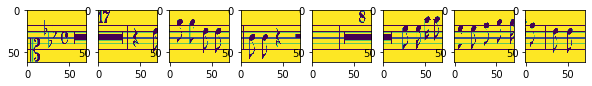

In [0]:
 plot(5)

In [0]:
from keras.models import Sequential, Model
import keras.backend
from keras.layers import Dense, Conv2D, Conv3D, Flatten, LSTM,MaxPooling2D, Input, Embedding, Permute,ConvLSTM2D
encoder_inputs = Input(shape=(568//71,62,71)) 
res = keras.layers.core.Reshape(target_shape=(568//71,62,71,1))(encoder_inputs)
lst_1 = ConvLSTM2D(filters=8,kernel_size=(5,5))(res)
dn = Dense(1)(lst_1)
res2 = keras.layers.core.Reshape(target_shape=(58,67))(dn)
dn2 = Dense(1781)(res2)
model2 = Model(encoder_inputs,dn2)
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        (None, 8, 62, 71)         0         
_________________________________________________________________
reshape_37 (Reshape)         (None, 8, 62, 71, 1)      0         
_________________________________________________________________
conv_lst_m2d_22 (ConvLSTM2D) (None, 58, 67, 8)         7232      
_________________________________________________________________
dense_27 (Dense)             (None, 58, 67, 1)         9         
_________________________________________________________________
reshape_38 (Reshape)         (None, 58, 67)            0         
_________________________________________________________________
dense_28 (Dense)             (None, 58, 1781)          121108    
Total params: 128,349
Trainable params: 128,349
Non-trainable params: 0
_________________________________________________________________


In [0]:
model2.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
model2.fit(X_train, y_train,
          batch_size=256,
          epochs=5)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
58744/58744 [==============================] - 4458s 76ms/step - loss: 4.3291 - acc: 0.0085
Epoch 2/5
58744/58744 [==============================] - 4507s 77ms/step - loss: 4.0326 - acc: 0.0114
Epoch 3/5
58744/58744 [==============================] - 4531s 77ms/step - loss: 4.0979 - acc: 0.0108
Epoch 4/5
58744/58744 [==============================] - 4419s 75ms/step - loss: 3.9667 - acc: 0.0259
Epoch 5/5
58744/58744 [==============================] - 4442s 76ms/step - loss: 3.9951 - acc: 0.0109


# I couldn't achieve much of a result with second dataset, probably because of my poor understanding of LSTM and namely how the multidimentional input is treated. I will continue my research untill the end of summer, and hopefully will achieve some results 